## Делаем настоящую нейросеть, классифицирующую изображения из датасета Fashion MNIST

Принципиальный момент этого ноутбука - нашу модель мы оборачиваем в класс, унаследованный от **nn.Module**

Обычный шаблон построения модели в **PyTorch** выглядит так:


```
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
```
Выполнение модели, или, другими словами, прямой проход, выполняется в методе **forward()**



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

/Users/ilkhom/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Для начала определимся с тем, где будут жить наши тензоры: на GPU или CPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

Загрузим датасет Fashion MNIST

In [3]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, 
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, 
                                             transform=transforms.Compose([transforms.ToTensor()])) 

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Инициализировать загрузчики данных

In [4]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

У нас есть 10 классов одежды, которые мы будем предсказывать

In [5]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Выведем некоторые параметры

Picture data shape: torch.Size([100, 1, 28, 28])
Dataset size: 60000
Ankle Boot


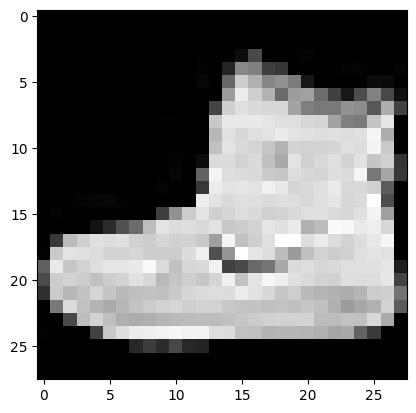

In [6]:
a = next(iter(train_loader))
print(f'Picture data shape: {a[0].size()}')
print('Dataset size:', len(train_set))

image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

Строим модель нейросети. Для этого наследуемся от класса nn.Module

Принципиально важно имплементировать метод forward() - он будет использован PyTorch для построения вычислительного графа

In [3]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=200)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=200, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

NameError: name 'nn' is not defined

Инициализируем модель и оптимизатор

In [24]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
# learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=200, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=200, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Тренируем нейросеть и проверяем качество на тестовом сете

Обычно тренировка занимает 20 минут на CPU и около 2 минут на GPU

In [27]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            # for images, labels in test_loader:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = images
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print(f"Epoch: {epoch}, Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy:4.2f}")


/Users/ilkhom/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 0, Iteration: 500, Loss: 0.29129835963249207, Accuracy: 91.31
Epoch: 1, Iteration: 1000, Loss: 0.2653680443763733, Accuracy: 90.58
Epoch: 2, Iteration: 1500, Loss: 0.2165704220533371, Accuracy: 90.34
Epoch: 3, Iteration: 2000, Loss: 0.30378445982933044, Accuracy: 91.53
Epoch: 4, Iteration: 2500, Loss: 0.12917132675647736, Accuracy: 91.81
Epoch: 4, Iteration: 3000, Loss: 0.21507394313812256, Accuracy: 89.16


Выведем график **accuracy**

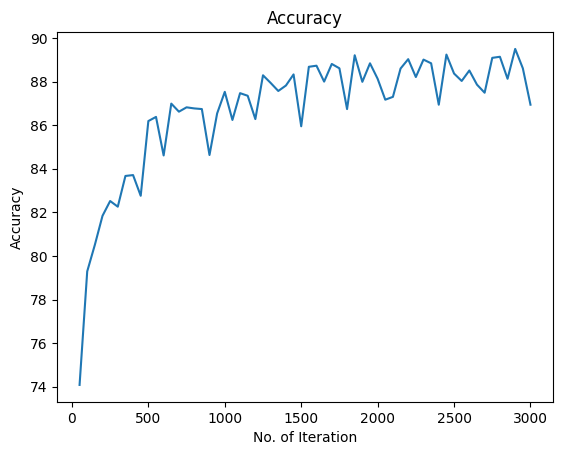

In [26]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

## Домашнее задание

Что вам необходимо сделать:
1. Обучите сеть без последних двух полносвязных слоев и дропаута **Какое accuracy на валидации получили?**
2. Попробуйте увеличить learning rate до 0.01. **Какое accuracy на валидации получили?**
3. Сделайте замер accuracy не на тестовом сете, а на трейнсете. **Какое значение получилось?**

Удачи!